<a href="https://colab.research.google.com/github/kareemullah123456789/big_data_advanced/blob/main/persisit_unpersisit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
spark.stop()

In [1]:
# Install required packages
!pip install pyspark pyngrok


In [2]:

import time
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyngrok import ngrok
import threading
import webbrowser


In [6]:

# Set ngrok auth token
ngrok.set_auth_token("2ztIY0fitbVIqJKlPqMVRwwWEkb_MZko6P65dpqoxfAo4rSD")

# Initialize Spark with UI enabled
spark = SparkSession.builder \
    .appName("PersistDemo") \
    .config("spark.ui.enabled", "true") \
    .config("spark.ui.port", "4040") \
    .config("spark.sql.adaptive.enabled", "false") \
    .getOrCreate()

# Start ngrok tunnel for Spark UI
public_url = ngrok.connect(4040)
print(f"🚀 Spark UI available at: {public_url}")
print("Click the link above to see DAG visualization!")


🚀 Spark UI available at: NgrokTunnel: "https://6b0a6e5b2b1f.ngrok-free.app" -> "http://localhost:4040"
Click the link above to see DAG visualization!


In [5]:
!ngrok start --all

ERROR:  Your configuration file must define at least one tunnel when using --all. To intentionally start no tunnels, use `ngrok start --none.`


In [7]:

# Create sample dataset
print("\n📊 Creating sample dataset...")
data = [(i, f"user_{i%1000}", i * 10, i % 5) for i in range(1, 100001)]  # 100K records
df = spark.createDataFrame(data, ["id", "name", "amount", "category"])

print(f"✅ Created DataFrame with {df.count():,} records")




📊 Creating sample dataset...
✅ Created DataFrame with 100,000 records


In [8]:


def measure_time(operation_name, func):
    """Measure execution time of operation"""
    print(f"\n⏱️  Executing: {operation_name}")
    start = time.time()
    result = func()
    end = time.time()
    duration = end - start
    print(f"   ✓ Completed in {duration:.3f} seconds")
    return result, duration

def demo_without_persist():
    """Demo without persist - shows recomputation in DAG"""
    print("\n" + "="*50)
    print("🔴 DEMO 1: WITHOUT PERSIST")
    print("="*50)

    times = []

    # Operation 1: Count
    _, t1 = measure_time("Count operation #1", lambda: df.count())
    times.append(t1)

    # Operation 2: Same count (will recompute)
    _, t2 = measure_time("Count operation #2 (recomputes)", lambda: df.count())
    times.append(t2)

    # Operation 3: Filter + Count (recomputes from start)
    _, t3 = measure_time("Filter + Count (recomputes)",
                        lambda: df.filter(df.amount > 50000).count())
    times.append(t3)

    # Operation 4: Aggregation (recomputes again)
    _, t4 = measure_time("Group by + Sum (recomputes)",
                        lambda: df.groupBy("category").sum("amount").count())
    times.append(t4)

    total_time = sum(times)
    print(f"\n📈 Total time without persist: {total_time:.3f} seconds")
    print("👀 Check Spark UI - each operation shows full DAG execution")

    return times, total_time


In [9]:

def demo_with_persist():
    """Demo with persist - shows cached data usage in DAG"""
    print("\n" + "="*50)
    print("🟢 DEMO 2: WITH PERSIST")
    print("="*50)

    times = []

    # Persist the DataFrame
    print("💾 Persisting DataFrame with MEMORY_AND_DISK...")
    df.persist(StorageLevel.MEMORY_AND_DISK)

    # Operation 1: Count (will cache data)
    _, t1 = measure_time("Count operation #1 (caches data)", lambda: df.count())
    times.append(t1)

    # Operation 2: Same count (uses cache)
    _, t2 = measure_time("Count operation #2 (uses cache)", lambda: df.count())
    times.append(t2)

    # Operation 3: Filter + Count (uses cache)
    _, t3 = measure_time("Filter + Count (uses cache)",
                        lambda: df.filter(df.amount > 50000).count())
    times.append(t3)

    # Operation 4: Aggregation (uses cache)
    _, t4 = measure_time("Group by + Sum (uses cache)",
                        lambda: df.groupBy("category").sum("amount").count())
    times.append(t4)

    total_time = sum(times)
    print(f"\n📈 Total time with persist: {total_time:.3f} seconds")
    print("👀 Check Spark UI - operations show 'InMemoryTableScan' in DAG")

    # Show storage info
    print(f"\n💾 Storage Level: {df.storageLevel}")
    print(f"🔄 Is Cached: {df.is_cached}")

    # Unpersist
    print("\n🧹 Unpersisting DataFrame...")
    df.unpersist()
    print(f"🔄 Is Cached after unpersist: {df.is_cached}")

    return times, total_time


In [12]:

def visualize_results(times_without, total_without, times_with, total_with):
    """Create performance comparison visualization"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Individual operation times
    operations = ['Count #1', 'Count #2', 'Filter+Count', 'GroupBy+Sum']
    x = range(len(operations))

    ax1.bar([i-0.2 for i in x], times_without, 0.4, label='Without Persist', color='red', alpha=0.7)
    ax1.bar([i+0.2 for i in x], times_with, 0.4, label='With Persist', color='green', alpha=0.7)
    ax1.set_xlabel('Operations')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_title('Individual Operation Times')
    ax1.set_xticks(x)
    ax1.set_xticklabels(operations, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Total time comparison
    methods = ['Without Persist', 'With Persist']
    totals = [total_without, total_with]
    colors = ['red', 'green']

    bars = ax2.bar(methods, totals, color=colors, alpha=0.7)
    ax2.set_ylabel('Total Time (seconds)')
    ax2.set_title('Total Execution Time Comparison')
    ax2.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, total in zip(bars, totals):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{total:.3f}s', ha='center', va='bottom')

    # Calculate and show improvement
    improvement = ((total_without - total_with) / total_without) * 100
    plt.figtext(0.5, 0.02, f'Performance Improvement: {improvement:.1f}%',
                ha='center', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()


In [13]:

def explain_storage_levels():
    """Explain different storage levels with examples"""
    print("\n" + "="*60)
    print("📚 STORAGE LEVELS EXPLAINED")
    print("="*60)

    storage_levels = {
        "MEMORY_ONLY": "Store in JVM heap (fastest, limited by memory)",
        "MEMORY_AND_DISK": "Memory first, spill to disk if needed (balanced)",
        "DISK_ONLY": "Store only on disk (slowest, unlimited space)",
        "MEMORY_ONLY_SER": "Serialized objects in memory (memory efficient)",
        "MEMORY_AND_DISK_SER": "Serialized with disk fallback"
    }

    for level, description in storage_levels.items():
        print(f"🔸 {level:20}: {description}")

    print("\n💡 When to use each:")
    print("   • MEMORY_ONLY: Small datasets, plenty of memory")
    print("   • MEMORY_AND_DISK: Most common choice (recommended)")
    print("   • DISK_ONLY: Very limited memory, large datasets")
    print("   • *_SER versions: When memory is at premium")

def demonstrate_dag_differences():
    """Show how DAG looks different with/without persist"""
    print("\n" + "="*60)
    print("🎯 DAG VISUALIZATION GUIDE")
    print("="*60)

    print("""
🔴 WITHOUT PERSIST - What you'll see in DAG:
   1. Each operation starts from data source
   2. Full lineage shown every time
   3. WholeStageCodegen stages repeated
   4. No cache indicators

🟢 WITH PERSIST - What you'll see in DAG:
   1. First operation: normal DAG + caching
   2. Subsequent operations: start with 'InMemoryTableScan'
   3. Shorter DAG (cache hit)
   4. Green cache indicators in UI

💡 Key DAG Elements to Look For:
   • InMemoryTableScan: Indicates cache hit
   • Exchange/Shuffle operations: Data movement
   • WholeStageCodegen: Optimized execution
   • Storage Level in cache tab
    """)


🎬 Starting Spark Persist/Unpersist Demo
🌐 Monitor DAG execution at: NgrokTunnel: "https://6b0a6e5b2b1f.ngrok-free.app" -> "http://localhost:4040"

📚 STORAGE LEVELS EXPLAINED
🔸 MEMORY_ONLY         : Store in JVM heap (fastest, limited by memory)
🔸 MEMORY_AND_DISK     : Memory first, spill to disk if needed (balanced)
🔸 DISK_ONLY           : Store only on disk (slowest, unlimited space)
🔸 MEMORY_ONLY_SER     : Serialized objects in memory (memory efficient)
🔸 MEMORY_AND_DISK_SER : Serialized with disk fallback

💡 When to use each:
   • MEMORY_ONLY: Small datasets, plenty of memory
   • MEMORY_AND_DISK: Most common choice (recommended)
   • DISK_ONLY: Very limited memory, large datasets
   • *_SER versions: When memory is at premium

🎯 DAG VISUALIZATION GUIDE

🔴 WITHOUT PERSIST - What you'll see in DAG:
   1. Each operation starts from data source
   2. Full lineage shown every time
   3. WholeStageCodegen stages repeated
   4. No cache indicators

🟢 WITH PERSIST - What you'll see in DAG:

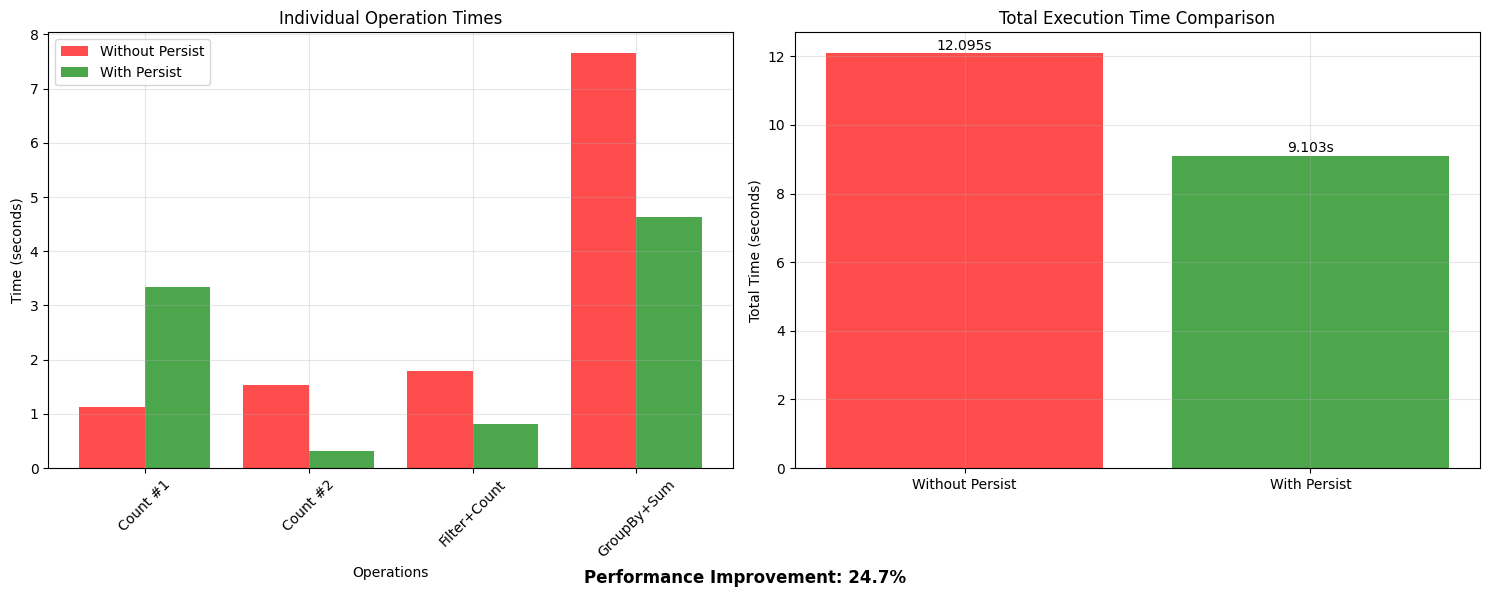


🎉 Results Summary:
   • Without persist: 12.095 seconds
   • With persist:    9.103 seconds
   • Improvement:     24.7% faster

🔗 Keep monitoring the Spark UI at: NgrokTunnel: "https://6b0a6e5b2b1f.ngrok-free.app" -> "http://localhost:4040"
   • Go to 'Storage' tab to see cached RDDs
   • Check 'SQL' tab for query execution plans
   • 'Jobs' tab shows individual job performance

⚠️  Keeping Spark session alive for UI monitoring...
   Run spark.stop() when done to clean up


In [14]:

# Run the complete demo
print("🎬 Starting Spark Persist/Unpersist Demo")
print(f"🌐 Monitor DAG execution at: {public_url}")

# Explain storage levels first
explain_storage_levels()

# Show what to look for in DAG
demonstrate_dag_differences()

# Run demos
times_without, total_without = demo_without_persist()
time.sleep(2)  # Brief pause to see DAG clearly
times_with, total_with = demo_with_persist()

# Show performance comparison
print("\n" + "="*50)
print("📊 PERFORMANCE ANALYSIS")
print("="*50)

visualize_results(times_without, total_without, times_with, total_with)

improvement = ((total_without - total_with) / total_without) * 100
print(f"\n🎉 Results Summary:")
print(f"   • Without persist: {total_without:.3f} seconds")
print(f"   • With persist:    {total_with:.3f} seconds")
print(f"   • Improvement:     {improvement:.1f}% faster")

print(f"\n🔗 Keep monitoring the Spark UI at: {public_url}")
print("   • Go to 'Storage' tab to see cached RDDs")
print("   • Check 'SQL' tab for query execution plans")
print("   • 'Jobs' tab shows individual job performance")

# Keep the session alive for UI monitoring
print("\n⚠️  Keeping Spark session alive for UI monitoring...")
print("   Run spark.stop() when done to clean up")

jobs >> stages >>>tasks

In [4]:
# Example showing Job → Stage → Task breakdown

# Your original DataFrame
df = spark.createDataFrame(data, ["id", "name", "amount", "category"])

# 🔴 SIMPLE OPERATION (1 Job, 1 Stage, Multiple Tasks)
result1 = df.count()
"""
Job 1: count()
├── Stage 1: Scan + Count
    ├── Task 1: Count partition 1
    ├── Task 2: Count partition 2
    ├── Task 3: Count partition 3
    └── Task 4: Count partition 4
"""

# 🟡 FILTER OPERATION (1 Job, 1 Stage, Multiple Tasks)
result2 = df.filter(df.amount > 50000).count()
"""
Job 2: filter().count()
├── Stage 1: Scan + Filter + Count
    ├── Task 1: Filter & count partition 1
    ├── Task 2: Filter & count partition 2
    ├── Task 3: Filter & count partition 3
    └── Task 4: Filter & count partition 4
"""

# 🔴 COMPLEX OPERATION (1 Job, 2 Stages, Multiple Tasks)
result3 = df.groupBy("category").sum("amount").count()
"""
Job 3: groupBy().sum().count()
├── Stage 1: Scan + Partial Aggregation
│   ├── Task 1: Scan & partial agg partition 1
│   ├── Task 2: Scan & partial agg partition 2
│   ├── Task 3: Scan & partial agg partition 3
│   └── Task 4: Scan & partial agg partition 4
│           ↓ SHUFFLE (data exchange)
├── Stage 2: Final Aggregation + Count
    ├── Task 1: Final agg for category group 1
    ├── Task 2: Final agg for category group 2
    └── Task 3: Count final result
"""

# 🟢 WITH PERSIST - CACHE IMPACT
df.persist()
result4 = df.groupBy("category").sum("amount").count()
"""
Job 4: groupBy().sum().count() WITH CACHE
├── Stage 1: InMemoryTableScan + Partial Aggregation
│   ├── Task 1: Read cache & partial agg partition 1
│   ├── Task 2: Read cache & partial agg partition 2
│   ├── Task 3: Read cache & partial agg partition 3
│   └── Task 4: Read cache & partial agg partition 4
│           ↓ SHUFFLE (reduced data)
├── Stage 2: Final Aggregation + Count
    ├── Task 1: Final agg for category group 1
    ├── Task 2: Final agg for category group 2
    └── Task 3: Count final result
"""

print("🎯 Key Differences with Persist:")
print("• Stage 1 tasks read from cache (faster)")
print("• Less data to shuffle between stages")
print("• Overall job completion time reduced")

🎯 Key Differences with Persist:
• Stage 1 tasks read from cache (faster)
• Less data to shuffle between stages
• Overall job completion time reduced
